## Introduction 
As a first working example, let's code up a few different covariance functions, and begin to see how this all works. We'll start with training a GP in the regression with Gaussian noise example. This notebook will follow closely the example in the docs.

In [ ]:
import altair as alt
import pandas as pd
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
import seaborn
import math

%matplotlib inline

In [ ]:
# Let's make some training data

x_train = torch.linspace(0,1,100)
y_train = torch.sin(x_train*(2*math.pi)) + torch.randn(x_train.size())*0.2

As the docs note, we'll need to *build* the GP model. GPyTorch provides the likelihood, mean kernel functions and full blown model. As with most pytorch models, we'll need to init a class with our parameters and define the forward method.

We'll focus on the exact likelihood/inference case.

In [ ]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, likelihood):
        super(ExactGPModel, self).__init__(x_train, y_train, likelihood)
        self.mean_function = gpytorch.means.ConstantMean()
        self.rbf_kernel = gpytorch.kernels.RBFKernel()
        
    def forward(self, x):
        x_mean = self.mean_function(x)
        covar_x = self.rbf_kernel(x)
        return gpytorch.distributions.MultivariateNormal(x_mean, covar_x)

In [ ]:
# Now we can initialize our likelihood and full model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_train, y_train, likelihood)

We'll need someway of marginalizing out the hyper-parameters of our kernel functions (e.g. variance and length scale). Fortunately, torch has many we can take advantage of in the ```torch.optim``` module. Also, our models by default extend ```torch.nn.Module```.

In [ ]:
model.train(),likelihood.train()

In [ ]:
# Now let's write the training loops to figure out what the lengthscale and noise parameters should be
model.train()
likelihood.train()
training_iter = 50

#Let's just use Adam
optimizer = torch.optim.Adam([{'params':model.parameters()}], lr=0.1)

'''We'll find the maximum likelihood estimate of each of the parameters, using the marginal log likelihood as our 
loss function. In this setting we are going to be able to calculate this exactly.
'''
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Let the fun begin:
for i in range(training_iter):
    # zero gradients from last iteration
    optimizer.zero_grad()
    #Calculate the predictions
    yhat = model(x_train)
    loss = -mll(yhat, y_train)
    
    # Calculate backprop gradients
    loss.backward()
    # print progress to screen
    print("Iter %d/%d - loss: %.3f   lengthscale: %.3f noise: %.3f"%(i, training_iter-1, loss.item(), 
                                                                    model.rbf_kernel.lengthscale.item(),
                                                                    model.likelihood.noise.item()))
    #Now, let's actually *update* the parameters
    optimizer.step()

Now that we know our parameters, let's make predictions! Just put the model in eval mode first and go from there

In [ ]:
# Evaluation model
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # The second call here uses LOVe to get faster predictive variances
    x_test = torch.linspace(-1,1,202)
    yhat_test = likelihood(model(x_test))

In [ ]:
# Now let's plot
with torch.no_grad():
    f, ax = plt.subplots(1,1, figsize=(8,6))
    
    lower, upper = yhat_test.confidence_region()
    ax.plot(x_train.numpy(), y_train.numpy(), 'k*')
    
    # Predictive means is a solid blue line
    ax.plot(x_test.numpy(), yhat_test.mean.numpy(), 'b')
    #Color in confidence region
    ax.fill_between(x_test.numpy(), lower.numpy(), upper.numpy(), alpha=0.3)
    ax.set_ylim([-3,3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

Clearly, the model fails to generalize very well outside of the domain on which we had training data. However, what if we had the hypothesis that the functionw as actually periodic? Let's encode that in the covariance function.

In [ ]:
# We'll repeat much of the above code, with a new exact gp model class defined below (other steps largely follow)
class ExactGPPeriodicModel(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, likelihood):
        super(ExactGPPeriodicModel, self).__init__(x_train, y_train, likelihood)
        self.mean_function = gpytorch.means.ConstantMean()
        self.rbf_kernel = gpytorch.kernels.RBFKernel()
        self.periodic_kernel = gpytorch.kernels.PeriodicKernel()
        
    def forward(self, x):
        x_mean = self.mean_function(x)
        # We can add together arbitrary positive semi-definite kernels!
        covar_x = self.rbf_kernel(x) + self.periodic_kernel(x)
        return gpytorch.distributions.MultivariateNormal(x_mean, covar_x)

In [ ]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
periodic_model = ExactGPPeriodicModel(x_train, y_train, likelihood)

In [ ]:
likelihood.train(), periodic_model.train()

In [ ]:
# Same training loop as above
# Now let's write the training loops to figure out what the lengthscale and noise parameters should be
periodic_model.train()
likelihood.train()
training_iter = 50

#Let's just use Adam
optimizer = torch.optim.Adam([{'params':model.parameters()}], lr=0.1)

'''We'll find the maximum likelihood estimate of each of the parameters, using the marginal log likelihood as our 
loss function. In this setting we are going to be able to calculate this exactly.
'''
periodic_mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, periodic_model)

# Let the fun begin:
for i in range(training_iter):
    # zero gradients from last iteration
    optimizer.zero_grad()
    #Calculate the predictions
    yhat = periodic_model(x_train)
    loss = -periodic_mll(yhat, y_train)
    
    # Calculate backprop gradients
    loss.backward()
    # print progress to screen
    print("Iter %d/%d - loss: %.3f   lengthscale: %.3f noise: %.3f  period_lengthscale: %.3f  period: %.3f"%(i, training_iter-1, loss.item(), 
                                                                    periodic_model.rbf_kernel.lengthscale.item(),
                                                                    periodic_model.likelihood.noise.item(),
                                                                    periodic_model.periodic_kernel.lengthscale.item(),
                                                                    periodic_model.periodic_kernel.period_length.item()))
    #Now, let's actually *update* the parameters
    optimizer.step()

In [ ]:
# Evaluation model
periodic_model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # The second call here uses LOVe to get faster predictive variances
    x_test = torch.linspace(-1,1,202)
    yhat_test = likelihood(periodic_model(x_test))

Not as smooth (and still a *lot* of uncertainty), but pretty good nonetheless

In [ ]:
# Now let's plot
with torch.no_grad():
    f, ax = plt.subplots(1,1, figsize=(8,6))
    
    lower, upper = yhat_test.confidence_region()
    ax.plot(x_train.numpy(), y_train.numpy(), 'k*')
    
    # Predictive means is a solid blue line
    ax.plot(x_test.numpy(), yhat_test.mean.numpy(), 'b')
    #Color in confidence region
    ax.fill_between(x_test.numpy(), lower.numpy(), upper.numpy(), alpha=0.3)
    ax.set_ylim([-3,3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

#### Let's draw a bunch of samples, rather than just plotting the 95% confidence interval

In [ ]:
f_pred = periodic_model(x_test)

In [ ]:
num_samples = 100

In [ ]:
yhat_samples = f_pred.sample(sample_shape = torch.Size([num_samples])).numpy()

In [ ]:
# Now let's plot
with torch.no_grad():
    f, ax = plt.subplots(1,1, figsize=(8,6))
    
    lower, upper = yhat_test.confidence_region()
    #Data
    ax.plot(x_train.numpy(), y_train.numpy(), 'k*')
    
    #Plot our samples from the predictive distribution
    for i in range(min(num_samples, 20)):
        ax.plot(x_test.numpy(), yhat_samples[i,:], 'b', linewidth=0.3)
    #Color in confidence region
#     ax.fill_between(x_test.numpy(), lower.numpy(), upper.numpy(), alpha=0.3)
    ax.set_ylim([-3,3])
    ax.legend(['Observed Data', 'Posterior Samples'])

Altair

In [ ]:
samples_plot.head()

In [ ]:
raw_samples = pd.DataFrame(yhat_samples[:10,:].T)
raw_samples.columns = ['sample_%d'%col for col in raw_samples.columns]
raw_samples['x'] = x_test.numpy()
samples_plot = pd.melt(raw_samples, id_vars='x', var_name='sample_id')

In [ ]:
altair_data = pd.DataFrame({'x':x_train.numpy(), 'obs':y_train.numpy()})
obs_chart = alt.Chart(altair_data).mark_point().encode(x='x', y='obs')

In [ ]:
nearest = alt.selection(type='single', nearest=True, on='mouseover', fields=['x'], empty='none')
selectors = alt.Chart(altair_data).mark_point().encode(
    x='x:Q',
    opacity=alt.value(0),
).add_selection(
    nearest
)

# Draw points on the line, and highlight based on selection
points = obs_chart.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, and highlight based on selection
text = obs_chart.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'obs:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart(altair_data).mark_rule(color='gray').encode(
    x='x:Q',
).transform_filter(
    nearest
)
(alt.layer(obs_chart, selectors, points, rules, text)+chart_1).interactive()

In [ ]:
chart_1 = alt.Chart(samples_plot).mark_line().encode(x='x', y='value', detail='sample_id')
(obs_chart.add_selection(nearest) + chart_1).interactive()#.configure_mark(opacity=0.3)

#### Samples from different kernel functions (assume constant mean function)
Now that we can see how to find MLE estimates of our kernel hyperparameters, but what if we just wanted to draw samples from different function *priors*? Let's proceed to do this below, working out way to as much of an app as possible (above has been largely exploratory/functional).


In [ ]:
kernel = gpytorch.kernels.RBFKernel()
#Let's do some fixed noise
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=torch.ones(100)*0.2)
x = torch.linspace(-1,1,100)

In [2]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, kernel_func,  likelihood):
        super(ExactGPModel, self).__init__(x_train, y_train, likelihood)
        self.mean_function = gpytorch.means.ConstantMean()
        self.kernel_func = kernel_func
        
    def forward(self, x):
        x_mean = self.mean_function(x)
        covar_x = self.kernel_func(x)
        return gpytorch.distributions.MultivariateNormal(x_mean, covar_x)

In [3]:
def plot_samples(x, torch_samples, max_samples = 50):
    samples, points = torch_samples.shape
    samples_to_plot = torch_samples.numpy()
    idx = np.random.choice(np.arange(samples), size = np.minimum(samples, max_samples), replace=False)
    raw_samples = pd.DataFrame(samples_to_plot[idx,:].T)
    raw_samples.columns = ['sample_%d'%col for col in raw_samples.columns]
    raw_samples['x'] = x.numpy()
    samples_plot = pd.melt(raw_samples, id_vars='x', var_name='sample_id')
    
    
    prior_samples = alt.Chart(samples_plot).mark_line().encode(x='x', y='value', detail='sample_id')
    return prior_samples.interactive()

In [4]:
def train_gp(gp_model, gp_likelihood, x_train, y_train, training_iter = 50):
    gp_model.train()
    gp_likelihood.train()
    training_iter = 50

    #Let's just use Adam
    optimizer = torch.optim.Adam([{'params':gp_model.parameters()}], lr=0.1)


    mll = gpytorch.mlls.ExactMarginalLogLikelihood(gp_likelihood, gp_model)

    # Let the fun begin:
    for i in range(training_iter):
        # zero gradients from last iteration
        optimizer.zero_grad()
        #Calculate the predictions
        yhat = gp_model(x_train)
        loss = -mll(yhat, y_train)
        # Calculate backprop gradients
        loss.backward()
        # print progress to screen
        #Now, let's actually *update* the parameters
        optimizer.step()
        
    return gp_model, gp_likelihood

In [36]:
import pdb

In [39]:
def sample_from_gp(kernel_string, train_x, train_y, llhood, **kwargs):

    kernels = ['Matern', 'RBF', 'Linear', 'Periodic']
    if kernel_string not in kernels:
        raise ValueError("Invalid kernel type. Expected one of: %s" % kernels)

    if kernel_string == 'Matern':
        kernel_func = gpytorch.kernels.MaternKernel(**kwargs)
    elif kernel_string == 'Periodic':
        kernel_func = gpytorch.kernels.PeriodicKernel(**kwargs)
    elif kernel_string == 'Linear':
        kernel_func = gpytorch.kernels.LinearKernel(**kwargs)
    elif kernel_string == 'RBF':
        kernel_func = gpytorch.kernels.RBFKernel(**kwargs)
    
    model = ExactGPModel(train_x, train_y, kernel_func, llhood)
    # "train" model
    if train_x is not None:
        model, llhood = train_gp(model, llhood, train_x, train_y)
    model.likelihood.noise = 1e-4    
    model.eval()
    likelihood.eval()
    
    with torch.no_grad():
        #Lets draw samples of the trained model at 100 test points
        x = torch.linspace(0, 1, 100)
        samples_ = model(x).sample(sample_shape=torch.Size([500]))
        observed_pred = llhood(model(x))
        lower, upper =observed_pred.confidence_region()
        if train_x is not None:
            f, ax = plt.subplots(1,1, figsize=(4,3))
            ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
            ax.plot(x.numpy(), observed_pred.mean.numpy(), 'b')
            ax.fill_between(x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    return plot_samples(x, samples_)
# likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=torch.ones(())*0.2)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
sample_from_gp('RBF', None, None, likelihood)

alt.Chart(...)

In [11]:
# likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=torch.ones((2))*0.2)

alt.LayerChart(...)

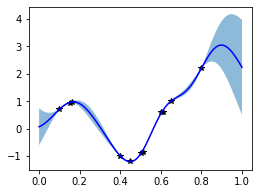

In [40]:
# Pseudo-code
# So we plot our samples from our prior.
# Idea: Append points to list or array, then make new torch tensor
x_obs = torch.tensor([0.8, 0.1, 0.45, 0.40, 0.5, 0.51, 0.6, 0.61, 0.65, 0.15, 0.16])
y_obs = torch.tensor([2.2, 0.7, -1.2, -1., -0.9, -0.85, 0.6, 0.61, 1., 0.95, 0.97])
# likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=torch.ones(x_obs.shape[0])*0.002)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# Observe Data
posterior_plot = sample_from_gp('RBF', x_obs, y_obs, likelihood)
observed_plot = alt.Chart(pd.DataFrame({'x':x_obs.numpy(),
                                          'value':y_obs.numpy()})).mark_circle(opacity=0.9, color='red',
                                                                              size=100).encode(x='x',y='value')
(posterior_plot + observed_plot).interactive()
# Condition
# Replot